In [1]:
# Import modules
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cf
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu

#luke added for running on dcc
import os
import sys
#luke added for loading to make daily means and keeping track of time in loop
import time as tm
import xarray as xr
import xesmf as xe

print('done loading modules')

done loading modules


In [2]:
years = np.arange(1950,2101,1)

experiment = 'ssp585'


In [3]:
datadir_pop_gpw = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_pop_gpw = 'gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_nclimgrid_min.nc'
ds_pop_gpw = xr.open_dataset(datadir_pop_gpw + fname_pop_gpw)
da_pop_gpw = ds_pop_gpw['population'].where(ds_pop_gpw['population'] > 0)

datadir_pop = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data//'
fname_pop = 'usa_ppp_2020_UNadj_constrained_resample_sum_nclimgrid.nc'
ds_pop = xr.open_dataset(datadir_pop + fname_pop)
da_pop = ds_pop['population'].where(ds_pop['population'] > 0)
regridder_gpw_worldpopnclimgrid = xe.Regridder(da_pop, da_pop_gpw, "bilinear")
#regridder_gpw_worldpopnclimgrid.to_netcdf()
da_pop = regridder_gpw_worldpopnclimgrid(da_pop)
#np.log(da_pop).plot()
#plt.title('log of population (for plotting purposes)')

datadir_svi = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_svi = 'svi_2020_tract_overall_nclimgrid.nc'
ds_svi = xr.open_dataset(datadir_svi + fname_svi)
da_svi = ds_svi['svi']

datadir_states = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_states = 'State_ID_from_zhouCroppedForStates_nclimgrid.nc'
ds_states = xr.open_dataset(datadir_states + fname_states)
da_states = ds_states['ID']

In [4]:
#JUST SVI
#name_nc = 'staresdm_cmip6_'+str(experiment)+'_conus_texas_tasmax_annual_popweight_high_svi_low_svi.nc'
#SOVI AND SVI BELOW
path_data = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
name_nc = 'staresdm_cmip6_'+str(experiment)+'_conus_tasmax_annual_popweight_GPWv4_2020_WorldPop_2020_Static_high_svi_low_svi_high_sovi_low_sovi.nc'

ds = xr.open_dataset(path_data + name_nc)
ds['time'] = np.arange(1950,2101,1)

conus_hi = ds['tasmax_popweighted_conus_worldpop_highsvi'][:-1,:] ## NOTE NOT USING TAIESM!!!
conus_lo = ds['tasmax_popweighted_conus_worldpop_lowsvi'][:-1,:] ## NOTE NOT USING TAIESM!!!
diff = conus_hi - conus_lo

conus_hi_sovi = ds['tasmax_popweighted_conus_worldpop_highsovi'][:-1,:] ## NOTE NOT USING TAIESM!!!
conus_lo_sovi = ds['tasmax_popweighted_conus_worldpop_lowsovi'][:-1,:] ## NOTE NOT USING TAIESM!!!
diff_sovi = conus_hi_sovi - conus_lo_sovi

## load nclimgrid tasmax so can put all obs+model violin plots together!

In [5]:
ds_nclimgrid = xr.open_dataset(path_data + 'nclimgrid_conus_tmax_annual_popweight_WorldPop2020_high_svi_low_svi.nc')

conus_nclimgrid_lo_allyears = ds_nclimgrid['tasmax_popweighted_conus_lowsvi']
conus_nclimgrid_hi_allyears = ds_nclimgrid['tasmax_popweighted_conus_highsvi']

## load global warming level data

In [6]:
temps = ['1','1.5','2','2.5','3','3.5','4']

usecols = ['CMIP6 Model','1','1.5','2','2.5','3','3.5','4']

# Read the CSV file
gwls = pd.read_csv(path_data + 'CMIP6_STARESDM_Models_GWLevels_ssp585.csv',usecols=usecols)

# View the first 5 rows
gwls.head()

models = gwls['CMIP6 Model']

In [7]:
models

0           ACCESS-CM2
1        ACCESS-ESM1-5
2          BCC-CSM2-MR
3            CMCC-ESM2
4              CanESM5
5     EC-Earth3-Veg-LR
6            EC-Earth3
7            FGOALS-g3
8             GFDL-CM4
9            GFDL-ESM4
10           INM-CM4-8
11           INM-CM5-0
12        IPSL-CM6A-LR
13          KACE-1-0-G
14           KIOST-ESM
15              MIROC6
16       MPI-ESM1-2-HR
17       MPI-ESM1-2-LR
18          MRI-ESM2-0
19               NESM3
20          NorESM2-LM
21          NorESM2-MM
22             TaiESM1
Name: CMIP6 Model, dtype: object

## find where various climate models pass warming thresholds in this ssp, average impacts for that model at that timeslice

In [8]:
#calculate mean change in maps at temperature anomaly level
for mi,model in enumerate(models[:-1]): #all but last if excluding TaiESM1- we are bc data corruption issue
    print(model)
    for ti,temp in enumerate(temps):
        if pd.isnull(gwls[str(temp)][mi]):
            
            conus_hi_slice = conus_hi.sel(model=mi,time=slice(1951,1970)).mean(dim='time')
            conus_hi_slice = conus_hi_slice.where(conus_hi_slice<0,'nan')
            conus_hi_slice = conus_hi_slice.assign_coords(gwl=temp)
            
            conus_lo_slice = conus_lo.sel(model=mi,time=slice(1951,1970)).mean(dim='time')
            conus_lo_slice = conus_lo_slice.where(conus_lo_slice<0,'nan')
            conus_lo_slice = conus_lo_slice.assign_coords(gwl=temp)
        else:
            yr = int(np.array(gwls[str(temp)][mi]))
            
            conus_hi_slice = conus_hi.sel(model=mi,time=slice(yr-9,yr+10)).mean(dim='time')
            conus_hi_slice = conus_hi_slice.assign_coords(gwl=temp)
            
            conus_lo_slice = conus_lo.sel(model=mi,time=slice(yr-9,yr+10)).mean(dim='time')
            conus_lo_slice = conus_lo_slice.assign_coords(gwl=temp)
            
        if ti == 0:
            conus_hi_slice_all_gwls = conus_hi_slice
            conus_lo_slice_all_gwls = conus_lo_slice
        else:
            conus_hi_slice_all_gwls = xr.concat((conus_hi_slice_all_gwls,conus_hi_slice),dim='gwl')
            conus_lo_slice_all_gwls = xr.concat((conus_lo_slice_all_gwls,conus_lo_slice),dim='gwl')
            
    if  mi == 0:
        conus_hi_slice_all_gwls_allmodels = conus_hi_slice_all_gwls
        conus_lo_slice_all_gwls_allmodels = conus_lo_slice_all_gwls
    else:
        conus_hi_slice_all_gwls_allmodels = xr.concat((conus_hi_slice_all_gwls_allmodels,conus_hi_slice_all_gwls),dim='model')
        conus_lo_slice_all_gwls_allmodels = xr.concat((conus_lo_slice_all_gwls_allmodels,conus_lo_slice_all_gwls),dim='model')
       

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CMCC-ESM2
CanESM5
EC-Earth3-Veg-LR
EC-Earth3
FGOALS-g3
GFDL-CM4
GFDL-ESM4
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM


## print average max temp exposure for each warming level

## for nClimGrid

In [9]:
lo_early = conus_nclimgrid_lo_allyears.sel(time=slice(1951,1980))
hi_early = conus_nclimgrid_hi_allyears.sel(time=slice(1951,1980))
diff_early = hi_early - lo_early

print('1951-1980 low svi median:',np.round(lo_early.median(dim='time').values,1),
      'range:', np.round(lo_early.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(lo_early.quantile(0.95,dim='time').values.astype(np.double),1))

print('1951-1980 high svi median:',np.round(hi_early.median(dim='time').values,1),
      'range:', np.round(hi_early.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(hi_early.quantile(0.95,dim='time').values.astype(np.double),1))

print('1951-1980 high vs low svi median:',np.round(diff_early.median(dim='time').values,1),
      'range:', np.round(diff_early.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(diff_early.quantile(0.95,dim='time').values.astype(np.double),1))

U1, p = mannwhitneyu(lo_early,hi_early)
print('pvalue for high vs low in early period:',p)
print('')

lo_late = conus_nclimgrid_lo_allyears.sel(time=slice(1994,2023))
hi_late = conus_nclimgrid_hi_allyears.sel(time=slice(1994,2023))
diff_late = hi_late - lo_late

print('1994-2023 low svi median:',np.round(lo_late.median(dim='time').values,1),
      'range:', np.round(lo_late.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(lo_late.quantile(0.95,dim='time').values.astype(np.double),1))

print('1994-2023 high svi median:',np.round(hi_late.median(dim='time').values,1),
      'range:', np.round(hi_late.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(hi_late.quantile(0.95,dim='time').values.astype(np.double),1))

print('11994-2023 high vs low svi median:',np.round(diff_late.median(dim='time').values,1),
      'range:', np.round(diff_late.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(diff_late.quantile(0.95,dim='time').values.astype(np.double),1))

U1, p = mannwhitneyu(lo_late,hi_late)
print('pvalue for high vs low in late period:',p)
print('')

1951-1980 low svi median: 35.3 range: 34.3 - 36.7
1951-1980 high svi median: 36.6 range: 36.0 - 37.7
1951-1980 high vs low svi median: 1.4 range: 0.9 - 1.9
pvalue for high vs low in early period: 1.3594320855421332e-07

1994-2023 low svi median: 35.9 range: 34.8 - 37.4
1994-2023 high svi median: 37.4 range: 36.5 - 38.6
11994-2023 high vs low svi median: 1.5 range: 0.9 - 2.0
pvalue for high vs low in late period: 6.527736457495676e-08



## for climate model data: print, significance

In [10]:
temps_paper = ['1.5','2','3']

for ti,temp in enumerate(temps_paper):
    
    lo = conus_lo_slice_all_gwls_allmodels.sel(gwl=str(temp))
    hi = conus_hi_slice_all_gwls_allmodels.sel(gwl=str(temp))
    diff = hi - lo
    vars()['diff_'+str(temp)] = diff.astype(int)
    U1, p = mannwhitneyu(lo.astype(int),hi.astype(int))
    
    print(str(temp),'C Warming: low svi median:',np.round(lo.median(dim='model').values,1),
          'range:', np.round(lo.quantile(0.05,dim='model').values.astype(np.double),1),'-',
          np.round(lo.quantile(0.95,dim='model').values.astype(np.double),1))
    
    print(str(temp),'C Warming: high svi median:',np.round(hi.median(dim='model').values,1),
          'range:', np.round(hi.quantile(0.05,dim='model').values.astype(np.double),1),'-',
          np.round(hi.quantile(0.95,dim='model').values.astype(np.double),1))
    
    print(str(temp),'C Warming: high vs low svi median:',np.round(diff.median(dim='model').values,1),
         'range:', np.round(diff.quantile(0.05,dim='model').values.astype(np.double),1),'-',
          np.round(diff.quantile(0.95,dim='model').values.astype(np.double),1))
    print('for warming level',str(temp),'significance of difference:',str(p))

    print('')

1.5 C Warming: low svi median: 37.3 range: 36.5 - 38.5
1.5 C Warming: high svi median: 38.7 range: 37.9 - 39.6
1.5 C Warming: high vs low svi median: 1.3 range: 1.0 - 1.5
for warming level 1.5 significance of difference: 6.334025854307133e-07

2 C Warming: low svi median: 38.2 range: 37.1 - 39.7
2 C Warming: high svi median: 39.4 range: 38.6 - 40.7
2 C Warming: high vs low svi median: 1.2 range: 0.9 - 1.7
for warming level 2 significance of difference: 4.13381691878107e-06

3 C Warming: low svi median: 39.5 range: 38.5 - 41.1
3 C Warming: high svi median: 40.6 range: 39.7 - 42.0
3 C Warming: high vs low svi median: 1.0 range: 0.7 - 1.5
for warming level 3 significance of difference: 9.089153911400968e-05



## statistical test to determine if differences are significantly different (mann-whitney)

In [11]:
for ti,temp in enumerate(temps[:-1]):
    
    lo = conus_lo_slice_all_gwls_allmodels.sel(gwl=str(temp)).astype(int)
    hi = conus_hi_slice_all_gwls_allmodels.sel(gwl=str(temp)).astype(int)
    diff = hi - lo
    
    vars()['diff_'+str(temp)] = diff
    #U1, p = mannwhitneyu(lo,hi)   
    
U1, p = mannwhitneyu(vars()['diff_1.5'],vars()['diff_2'])
print(U1,p)

U1, p = mannwhitneyu(vars()['diff_2'],vars()['diff_3'])
print(U1,p)
    

245.0 0.9423114071243224
258.0 0.6550025611679644


## how many climate models exceed thresholds at warming levels?

In [12]:
temp = 3
lo = conus_lo_slice_all_gwls_allmodels.sel(gwl=str(temp))
hi = conus_hi_slice_all_gwls_allmodels.sel(gwl=str(temp))

lo.where(lo > 39).count(dim='model')

hi.where(hi > 39).count(dim='model')

<xarray.DataArray 'tasmax_popweighted_conus_worldpop_highsvi' ()> Size: 8B
array(22)
Coordinates:
    gwl      <U3 12B '3'

## now for global warming levels

In [13]:
# creating a list of index names
index_values = ['Low SVI','High-SVI']
   
# creating a list of column names
column_values = models #

length_obs = 30
nmodels = 22

## Plot exceedance in Low- and High-SVI separately (a) and difference (b)

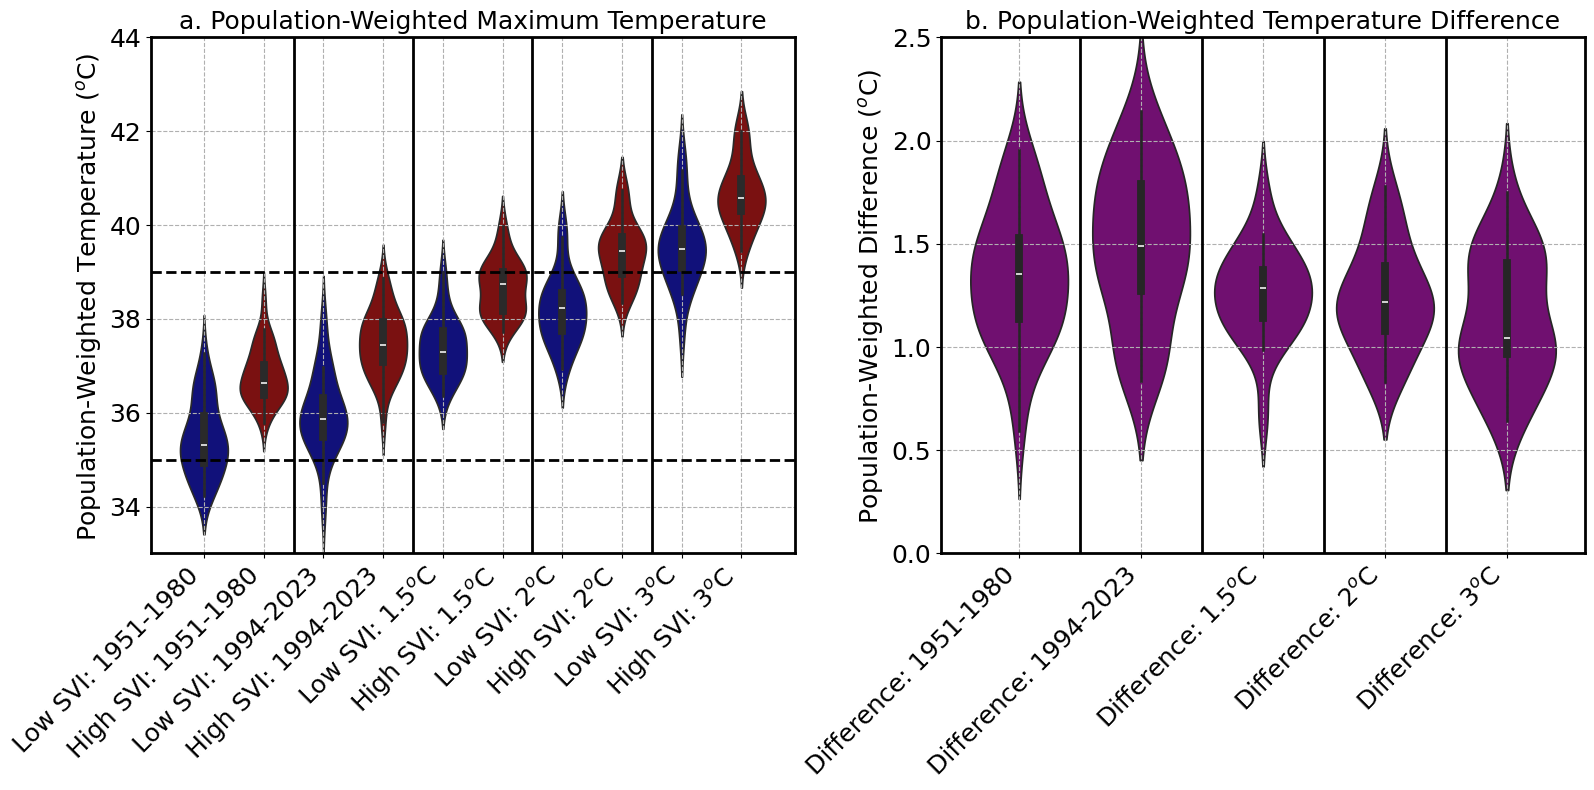

In [14]:
df = pd.DataFrame({'Low SVI: 1951-1980': conus_nclimgrid_lo_allyears.sel(time=slice(1951,1980)),
                   'High SVI: 1951-1980': conus_nclimgrid_hi_allyears.sel(time=slice(1951,1980)),
                   'Low SVI: 1994-2023': conus_nclimgrid_lo_allyears.sel(time=slice(1994,2023)),
                   'High SVI: 1994-2023': conus_nclimgrid_hi_allyears.sel(time=slice(1994,2023)),
                   'Low SVI: 1.5$^o$C': np.concat((conus_lo_slice_all_gwls_allmodels.sel(gwl='1.5') , [np.nan]*(length_obs - nmodels))),
                   'High SVI: 1.5$^o$C': np.concat((conus_hi_slice_all_gwls_allmodels.sel(gwl='1.5'), [np.nan]*(length_obs - nmodels))),
                   'Low SVI: 2$^o$C': np.concat((conus_lo_slice_all_gwls_allmodels.sel(gwl='2'), [np.nan]*(length_obs - nmodels))),
                   'High SVI: 2$^o$C': np.concat((conus_hi_slice_all_gwls_allmodels.sel(gwl='2'), [np.nan]*(length_obs - nmodels))),
                   'Low SVI: 3$^o$C': np.concat((conus_lo_slice_all_gwls_allmodels.sel(gwl='3'), [np.nan]*(length_obs - nmodels))),
                   'High SVI: 3$^o$C': np.concat((conus_hi_slice_all_gwls_allmodels.sel(gwl='3'), [np.nan]*(length_obs - nmodels))),
                  })

my_pal = {"Low SVI: 1951-1980": "darkblue",
          "High SVI: 1951-1980": "darkred",
         "Low SVI: 1994-2023": "darkblue",
          "High SVI: 1994-2023": "darkred",
          "Low SVI: 1.5$^o$C": "darkblue",
          "High SVI: 1.5$^o$C": "darkred",
         "Low SVI: 2$^o$C": "darkblue",
          "High SVI: 2$^o$C": "darkred",
         "Low SVI: 3$^o$C": "darkblue",
          "High SVI: 3$^o$C": "darkred",}


fsize = 18

fig = plt.figure(figsize=(16,8))

ax = plt.subplot(1,2,1)
sns.violinplot(ax=ax,data=df,palette=my_pal)

plt.title('a. Population-Weighted Maximum Temperature',fontsize=fsize)
#plt.xlim([1950,2021])
plt.ylabel('Population-Weighted Temperature ($^o$C) ',fontsize=fsize)

ax.tick_params(axis='x', which='major', labelsize=fsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', va='top')

plt.axhline(y=35, linewidth = 2, color='k', linestyle='--')
#plt.axhline(y=37, linewidth = 2, color='k', linestyle='--')
plt.axhline(y=39, linewidth = 2, color='k', linestyle='--')

plt.vlines(1.5,32,48,linewidth = 2, color='k', linestyle='-')
plt.vlines(3.5,32,48,linewidth = 2, color='k', linestyle='-')
plt.vlines(5.5,32,48,linewidth = 2, color='k', linestyle='-')
plt.vlines(7.5,32,48,linewidth = 2, color='k', linestyle='-')
#plt.ylabel('Density [-]',fontsize=fsize)
plt.ylim([33,44])
plt.yticks(fontsize=fsize)
#plt.legend(fontsize=fsize)
plt.grid(linestyle='--')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()



#### NOW FOR SECOND PANEL


df = pd.DataFrame({'Difference: 1951-1980': conus_nclimgrid_hi_allyears.sel(time=slice(1951,1980)) - conus_nclimgrid_lo_allyears.sel(time=slice(1951,1980)),
                   'Difference: 1994-2023': conus_nclimgrid_hi_allyears.sel(time=slice(1994,2023)) - conus_nclimgrid_lo_allyears.sel(time=slice(1994,2023)),
                   'Difference: 1.5$^o$C': np.concat((conus_hi_slice_all_gwls_allmodels.sel(gwl='1.5') - conus_lo_slice_all_gwls_allmodels.sel(gwl='1.5'), [np.nan]*(length_obs - nmodels))),
                   'Difference: 2$^o$C': np.concat((conus_hi_slice_all_gwls_allmodels.sel(gwl='2') - conus_lo_slice_all_gwls_allmodels.sel(gwl='2'), [np.nan]*(length_obs - nmodels))),
                   'Difference: 3$^o$C': np.concat((conus_hi_slice_all_gwls_allmodels.sel(gwl='3') - conus_lo_slice_all_gwls_allmodels.sel(gwl='3'), [np.nan]*(length_obs - nmodels))),
                  })

my_pal = {"Difference: 1951-1980": "purple",
          "Difference: 1994-2023": "purple",
          "Difference: 1.5$^o$C": "purple",
         "Difference: 2$^o$C": "purple",
         "Difference: 3$^o$C": "purple",
         }


ax = plt.subplot(1,2,2)
sns.violinplot(ax=ax,data=df,palette=my_pal)

plt.title('b. Population-Weighted Temperature Difference',fontsize=fsize)
#plt.xlim([1950,2021])
plt.ylabel('Population-Weighted Difference ($^o$C) ',fontsize=fsize)

ax.tick_params(axis='x', which='major', labelsize=fsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', va='top')

plt.vlines(0.5,0,2.5,linewidth = 2, color='k', linestyle='-')
plt.vlines(1.5,0,2.5,linewidth = 2, color='k', linestyle='-')
plt.vlines(2.5,0,2.5,linewidth = 2, color='k', linestyle='-')
plt.vlines(3.5,0,2.5,linewidth = 2, color='k', linestyle='-')
#plt.ylabel('Density [-]',fontsize=fsize)
plt.ylim([0,2.5])
plt.yticks(fontsize=fsize)
#plt.legend(fontsize=fsize)
plt.grid(linestyle='--')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()


#save figure
fig.savefig('figures/' + 'Figure_2',dpi=300,bbox_inches='tight')